<a href="https://colab.research.google.com/github/sanjabh11/Projects/blob/master/Goodbooks_10k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading related library

In [0]:
#Read more details from https://github.com/TannerGilbert/Tutorials/blob/master/FastAI/Book%20Recommendation%20System.ipynb
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *
from fastai.collab import *
import numpy as np
import pandas as pd
import re

# Pre-Porcessing

The train.csv file contains **Label** column with pixel values. If we think it as **filename, label** pair, all we need is a filename for each of our data

Let's create a filename for each of the training data, I used index of each example as filename. The idea here is besides label, we need to prepare each data with a name

For example, training set item 0, we name it 0. filename = 0, label =1

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets list -s goodbooks

ref                            title             size  lastUpdated          downloadCount  
-----------------------------  ---------------  -----  -------------------  -------------  
zygmunt/goodbooks-10k          goodbooks-10k     12MB  2017-09-02 15:34:30           7651  
jealousleopard/goodreadsbooks  Goodreads-books  632KB  2019-06-14 16:35:05             41  


In [0]:
!mkdir books && kaggle datasets download -d zygmunt/goodbooks-10k && unzip goodbooks-10k.zip -d books

 77% 9.00M/11.7M [00:00<00:00, 39.7MB/s]
100% 11.7M/11.7M [00:00<00:00, 46.4MB/s]
Archive:  goodbooks-10k.zip
  inflating: books/book_tags.csv     
  inflating: books/books.csv         
  inflating: books/ratings.csv       
  inflating: books/sample_book.xml   
  inflating: books/tags.csv          
  inflating: books/to_read.csv       


In [0]:
path = Path('/content/books')
path.ls()

[PosixPath('/content/books/tags.csv'),
 PosixPath('/content/books/books.csv'),
 PosixPath('/content/books/to_read.csv'),
 PosixPath('/content/books/sample_book.xml'),
 PosixPath('/content/books/book_tags.csv'),
 PosixPath('/content/books/ratings.csv')]

In [0]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [0]:
data = CollabDataBunch.from_df(ratings, seed=42, valid_pct=0.2, user_name='user_id', item_name='book_id', rating_name='rating')

In [0]:
data.show_batch()


user_id,book_id,target
45524,4597,3.0
50101,671,5.0
25634,3810,4.0
41907,5437,3.0
44175,1780,4.0


In [0]:
ratings.rating.min(), ratings.rating.max()

(1, 5)

# EmbeddingDotBias Model

In [0]:
learn = collab_learner(data, n_factors=40, y_range=(0.5, 5.5), wd=1e-1)

In [0]:
learn.summary()

In [0]:
#Free GPU memory
del learn
gc.collect()

7610

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


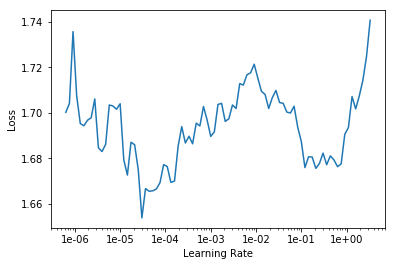

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(2, 2e-5)

epoch,train_loss,valid_loss,time
0,1.680971,1.681635,01:23
1,1.660585,1.672453,01:24


#EmbeddingNN Model


In [0]:
learn = collab_learner(data, use_nn=True, emb_szs={'user_id': 40, 'book_id':40}, layers=[256, 128], y_range=(0.5, 5.5))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


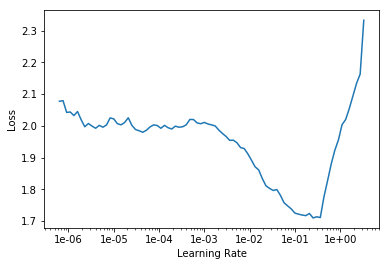

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, 1e-2)


epoch,train_loss,valid_loss,time
0,0.762798,0.768651,01:43
1,0.766961,0.756521,01:43
2,0.662114,0.730340,01:42
3,0.654460,0.712709,01:42
4,0.574639,0.726478,01:42


In [0]:
learn.save('goodbooks-nn-1')

# Interpretation


In [0]:
books = pd.read_csv(path/'books.csv')
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [0]:
g = ratings.groupby('book_id')['rating'].count()
top_books = g.sort_values(ascending=False).index.values[:1000]
top_books = top_books.astype(str)
top_books[:10]

array(['5000', '3315', '3313', '3312', '3311', '3309', '3308', '3307', '3306', '3304'], dtype='<U21')

In [0]:
top_books_with_name = []
for book in top_books:
    top_books_with_name.append(books[(books['book_id']==int(book))]['title'].iloc[0])
top_books_with_name = np.array(top_books_with_name)
top_books_with_name